# Modeling Crop Yield

In [35]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

## Parameters

In [3]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2"
country_code = "ZMB"
points = "4"
num_features = "1000"
feature_file_name = (f'{satellite}_{country_code}_{points}'
                     f'k-points_{num_features}-features')

weight_file_name = (f'{country_code}_crop_weights{points}k-points')

## Boundaries 

In [4]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [5]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
crop_df = crop_df.set_index('district')
# crop_df

In [6]:
list(set(crop_districts) - set(country_districts))

['Ikelenge', 'Mafinga']

In [7]:
list(set(country_districts) - set(crop_districts))

[]

In [8]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [9]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [10]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [40]:
features = geopandas.GeoDataFrame()
for yr in range(2016, 2019):
    print("Opening:", yr)
    print(f"File: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather") 
    features_x = features_x.set_index(['lon','lat', "year", 'month']).unstack()
    features_x.columns = features_x.columns.map(lambda x: '{}_{}'.format(*x))
    features_x = features_x.reset_index()
    features_x = geopandas.GeoDataFrame(
        features_x, 
        geometry = geopandas.points_from_xy(x = features_x.lon, y = features_x.lat)
        , crs='EPSG:4326'
    )#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
    features_x = features_x.drop(['lon', 'lat'], axis = 1)
    
    print("Joining:", yr)
    country_x = country_crop[country_crop.year == yr]
    adm_features = features_x.sjoin(country_x, how = 'left', predicate = 'within')
    
    print("Appending:", yr)
    features = geopandas.GeoDataFrame(
        pd.concat([features, adm_features], axis = 0), #, ignore_index=True),
        crs = 'EPSG:4326'
    ).reset_index(drop = True)
    print("features.shape:", features.shape)
    print("")

Opening: 2016
File: sentinel-2_ZMB_4k-points_1000-features_2016.feather
Joining: 2016
Appending: 2016
features.shape: (3772, 4005)

Opening: 2017
File: sentinel-2_ZMB_4k-points_1000-features_2017.feather
Joining: 2017
Appending: 2017
features.shape: (7544, 4005)

Opening: 2018
File: sentinel-2_ZMB_4k-points_1000-features_2018.feather
Joining: 2018
Appending: 2018
features.shape: (11316, 4005)



In [41]:
features

,year_left,0_3,0_4,0_5,0_6,1_3,1_4,1_5,1_6,2_3,...,998_5,998_6,999_3,999_4,999_5,999_6,geometry,index_right,year_right,yield_mt
0,2016,0.0,0.0,0.0,0.0,1.757533,1.757533,1.757533,1.757533,0.0,...,0.008293,0.008293,1.388580,1.388580,1.388580,1.388580,POINT (21.98512 -14.89559),NaN,NaN,NaN
1,2016,0.0,0.0,0.0,0.0,1.902201,1.902201,1.902201,1.902201,0.0,...,0.000000,0.000000,1.457174,1.457174,1.457174,1.457174,POINT (21.98927 -14.71546),NaN,NaN,NaN
2,2016,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,POINT (21.99336 -14.53532),NaN,NaN,NaN
3,2016,0.0,0.0,0.0,0.0,1.547699,1.547699,1.547699,1.547699,0.0,...,0.002479,0.002479,1.372192,1.372192,1.372192,1.372192,POINT (21.99740 -14.35518),NaN,NaN,NaN
4,2016,0.0,0.0,0.0,0.0,0.396543,0.396543,0.396543,0.396543,0.0,...,0.008106,0.008106,1.171392,1.171392,1.171392,1.171392,POINT (22.00138 -14.17504),Kalabo,2016.0,0.379483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11311,2018,0.0,0.0,0.0,0.0,1.242001,1.242001,1.242001,1.242001,0.0,...,0.004559,0.004559,1.311491,1.311491,1.311491,1.311491,POINT (33.42622 -12.34268),Lundazi,2018.0,2.351544
11312,2018,0.0,0.0,0.0,0.0,0.092287,0.092287,0.092287,0.092287,0.0,...,0.115839,0.115839,1.003269,1.003269,1.003269,1.003269,POINT (33.47087 -10.27385),Isoka,2018.0,3.400556
11313,2018,0.0,0.0,0.0,0.0,0.251126,0.251126,0.251126,0.251126,0.0,...,0.073533,0.073533,1.042379,1.042379,1.042379,1.042379,POINT (33.47457 -10.45358),Isoka,2018.0,3.400556
11314,2018,0.0,0.0,0.0,0.0,0.132159,0.132159,0.132159,0.132159,0.0,...,0.170434,0.170434,0.986541,0.986541,0.986541,0.986541,POINT (33.47835 -10.63331),Isoka,2018.0,3.400556


In [42]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [43]:
#features['year_right']
features = features.dropna(subset = ['index_right']).drop(columns = ['year_right']).rename(columns = {'index_right': 'district', 'year_left':'year'}).reset_index(drop = True)
#features = features.dropna(subset=['index_right']).drop(['year_right', "index_3", "index_4", "index_5", "index_6"], axis = 1).rename(columns = {"index_right": "district", "year_left": "year"}).reset_index(drop = True)

In [44]:
features

,year,0_3,0_4,0_5,0_6,1_3,1_4,1_5,1_6,2_3,...,998_4,998_5,998_6,999_3,999_4,999_5,999_6,geometry,district,yield_mt
0,2016,0.0,0.0,0.0,0.0,0.396543,0.396543,0.396543,0.396543,0.0,...,0.008106,0.008106,0.008106,1.171392,1.171392,1.171392,1.171392,POINT (22.00138 -14.17504),Kalabo,0.379483
1,2016,0.0,0.0,0.0,0.0,0.849694,0.849694,0.849694,0.849694,0.0,...,0.011911,0.011911,0.011911,1.256599,1.256599,1.256599,1.256599,POINT (22.00531 -13.99489),Lukulu,1.119942
2,2016,0.0,0.0,0.0,0.0,0.437855,0.437855,0.437855,0.437855,0.0,...,0.008107,0.008107,0.008107,1.179152,1.179152,1.179152,1.179152,POINT (22.00918 -13.81474),Lukulu,1.119942
3,2016,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,POINT (22.01300 -13.63459),Zambezi,1.725293
4,2016,0.0,0.0,0.0,0.0,0.535233,0.535233,0.535233,0.535233,0.0,...,0.008217,0.008217,0.008217,1.206042,1.206042,1.206042,1.206042,POINT (22.01676 -13.45443),Zambezi,1.725293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11230,2018,0.0,0.0,0.0,0.0,1.242001,1.242001,1.242001,1.242001,0.0,...,0.004559,0.004559,0.004559,1.311491,1.311491,1.311491,1.311491,POINT (33.42622 -12.34268),Lundazi,2.351544
11231,2018,0.0,0.0,0.0,0.0,0.092287,0.092287,0.092287,0.092287,0.0,...,0.115839,0.115839,0.115839,1.003269,1.003269,1.003269,1.003269,POINT (33.47087 -10.27385),Isoka,3.400556
11232,2018,0.0,0.0,0.0,0.0,0.251126,0.251126,0.251126,0.251126,0.0,...,0.073533,0.073533,0.073533,1.042379,1.042379,1.042379,1.042379,POINT (33.47457 -10.45358),Isoka,3.400556
11233,2018,0.0,0.0,0.0,0.0,0.132159,0.132159,0.132159,0.132159,0.0,...,0.170434,0.170434,0.170434,0.986541,0.986541,0.986541,0.986541,POINT (33.47835 -10.63331),Isoka,3.400556


In [45]:
features['999_3'][0]

1.1713919639587402

In [46]:
features['999_4'][0]

1.1713919639587402

In [47]:
features['999_5'][0]

1.1713919639587402

In [48]:
features['999_6'][0]

1.1713919639587402

In [49]:
features[features.year == 2017]

,year,0_3,0_4,0_5,0_6,1_3,1_4,1_5,1_6,2_3,...,998_4,998_5,998_6,999_3,999_4,999_5,999_6,geometry,district,yield_mt
3745,2017,0.0,0.0,0.0,0.0,0.488075,0.488075,0.488075,0.488075,0.000000,...,0.008437,0.008437,0.008437,1.208836,1.208836,1.208836,1.208836,POINT (22.00138 -14.17504),Kalabo,0.506769
3746,2017,0.0,0.0,0.0,0.0,1.106330,1.106330,1.106330,1.106330,0.000000,...,0.011485,0.011485,0.011485,1.310084,1.310084,1.310084,1.310084,POINT (22.00531 -13.99489),Lukulu,1.096529
3747,2017,0.0,0.0,0.0,0.0,0.858217,0.858217,0.858217,0.858217,0.000000,...,0.007505,0.007505,0.007505,1.263855,1.263855,1.263855,1.263855,POINT (22.00918 -13.81474),Lukulu,1.096529
3748,2017,0.0,0.0,0.0,0.0,1.141032,1.141032,1.141032,1.141032,0.000000,...,0.004198,0.004198,0.004198,1.317249,1.317249,1.317249,1.317249,POINT (22.01300 -13.63459),Zambezi,1.490456
3749,2017,0.0,0.0,0.0,0.0,0.029225,0.029225,0.029225,0.029225,0.000000,...,0.112880,0.112880,0.112880,1.023804,1.023804,1.023804,1.023804,POINT (22.01676 -13.45443),Zambezi,1.490456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7485,2017,0.0,0.0,0.0,0.0,1.003579,1.003579,1.003579,1.003579,0.000000,...,0.005943,0.005943,0.005943,1.279879,1.279879,1.279879,1.279879,POINT (33.42622 -12.34268),Lundazi,3.266220
7486,2017,0.0,0.0,0.0,0.0,0.223227,0.223227,0.223227,0.223227,0.000000,...,0.032291,0.032291,0.032291,1.113137,1.113137,1.113137,1.113137,POINT (33.47087 -10.27385),Isoka,3.386449
7487,2017,0.0,0.0,0.0,0.0,0.565861,0.565861,0.565861,0.565861,0.000011,...,0.022157,0.022157,0.022157,1.184763,1.184763,1.184763,1.184763,POINT (33.47457 -10.45358),Isoka,3.386449
7488,2017,0.0,0.0,0.0,0.0,0.229352,0.229352,0.229352,0.229352,0.000000,...,0.081625,0.081625,0.081625,1.081334,1.081334,1.081334,1.081334,POINT (33.47835 -10.63331),Isoka,3.386449


In [50]:
if satellite == "landsat-8-c2-l2":
    na = features[features.isna().any(axis = 1)]
    na.plot(figsize = (15,15), markersize = 1)
    # plt.savefig(f'images/nans.jpg', dpi=300)
    features = features.dropna()

In [51]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

In [52]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

## Model

In [53]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [54]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [55]:
len(y_all)

216

In [56]:
len(x_train)

172

In [57]:
len(x_test)

44

In [58]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [59]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.22


In [61]:
# y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

# plt.figure()
# plt.scatter(y_pred, y_all, alpha=1, s=4)
# plt.xlabel("Predicted", fontsize=15)
# plt.ylabel("Ground Truth", fontsize=15)
# plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
# plt.title(f"Model applied to all data n = {len(x_all)}, R$^2$ = {(r2_score(y_all, y_pred)):0.2f}",
#           fontsize=12, y=1)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.text(0.1, .75,
#          s="R$^2$ = %0.2f" % (r2_score(y_all, y_pred)),
#          fontsize=15, fontweight="bold")

# m, b = np.polyfit(y_pred, y_all, 1)
# plt.plot(y_pred, m * y_pred + b, color="black")
# plt.gca().spines.right.set_visible(False)
# plt.gca().spines.top.set_visible(False)

# plt.show()
# plt.close()

In [62]:
# spearmanr(y_pred, y_all)

In [63]:
# pearsonr(y_pred, y_all)

In [64]:
# spearmanr(y_pred, y_all)

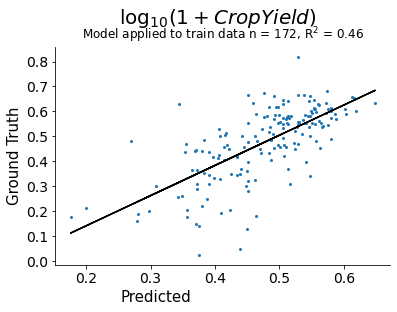

In [60]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [61]:
r2_score(y_train, y_pred)

0.4621277776859607

In [62]:
pearsonr(y_pred, y_train)

(0.6901690409244966, 1.1589350940677987e-25)

In [63]:
spearmanr(y_pred, y_train)

SpearmanrResult(correlation=0.6910171683006416, pvalue=9.569040430842197e-26)

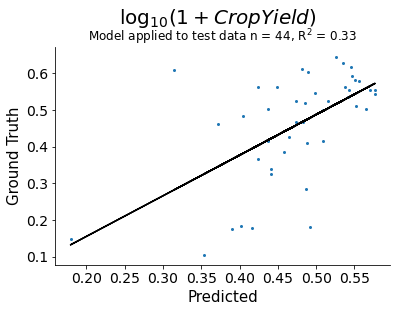

In [64]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [65]:
r2_score(y_test, y_pred)

0.33371482330297386

In [66]:
pearsonr(y_pred, y_test)

(0.5893793154588252, 2.5610461268818166e-05)

In [67]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.5558844256518675, pvalue=8.949667339098341e-05)

In [68]:
pred_features = features.copy()
x_all = pred_features.drop(['year', 'geometry', 'district', 'yield_mt'], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [69]:
plot_features = pred_features[pred_features.year == 2016]
# pred_features

<AxesSubplot:>

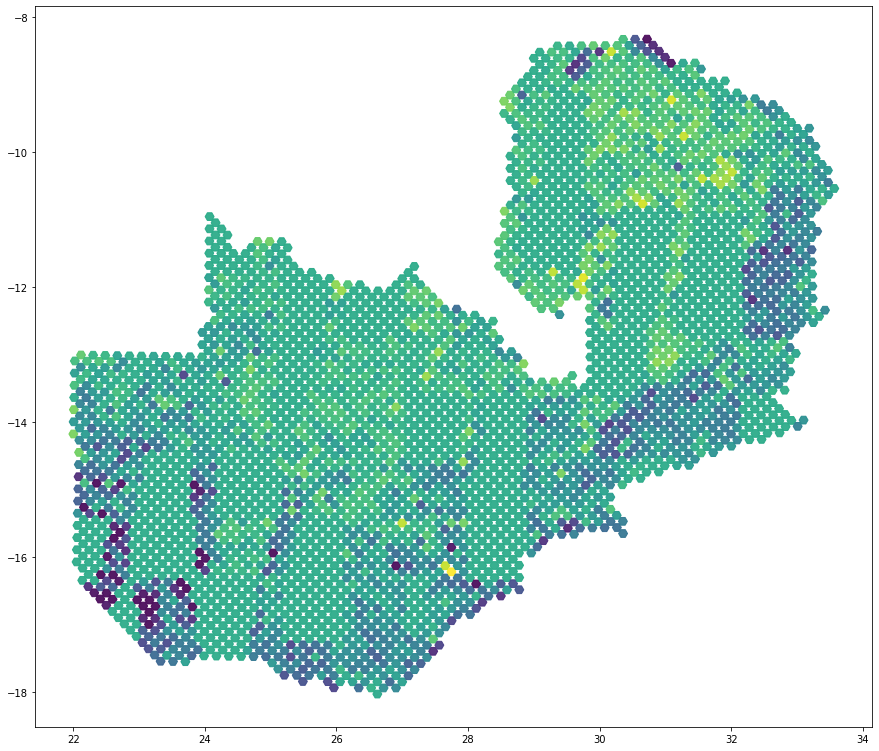

In [70]:
plot_features.plot(figsize = (15,15),
                   marker='H',
                   # legend = True,
                   markersize = 80,
                   alpha = .9,
                   column = 'fit')